# libraries

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import random
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import ast
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from itertools import chain
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split

2025-09-06 10:22:29.287813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757154149.512566      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757154149.571561      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# loading the dataset

In [2]:
import pandas as pd          # for data handling
import gdown                 # for downloading files from Google Drive

# Google Drive share links
train_file_link = "https://drive.google.com/file/d/1lRLZyebOdT2UIRvrPKJoE4a6TqGxczZG/view?usp=sharing"
test_file_link  = "https://drive.google.com/file/d/1NMHO5rEzDoY8v4SQoLXoXl2h8yrrvegs/view?usp=drive_link"

# Extract file IDs from the links
train_id = train_file_link.split("/")[-2]
test_id  = test_file_link.split("/")[-2]

# Download files using gdown and save locally
gdown.download(f"https://drive.google.com/uc?id={train_id}", "train.csv", quiet=False)
gdown.download(f"https://drive.google.com/uc?id={test_id}",  "test.csv",  quiet=False)

# Load CSV files into pandas DataFrames
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")


Downloading...
From (original): https://drive.google.com/uc?id=1lRLZyebOdT2UIRvrPKJoE4a6TqGxczZG
From (redirected): https://drive.google.com/uc?id=1lRLZyebOdT2UIRvrPKJoE4a6TqGxczZG&confirm=t&uuid=5fdb7936-cf59-44a1-a59d-5b42d260399a
To: /kaggle/working/train.csv
100%|██████████| 165M/165M [00:01<00:00, 118MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1NMHO5rEzDoY8v4SQoLXoXl2h8yrrvegs
From (redirected): https://drive.google.com/uc?id=1NMHO5rEzDoY8v4SQoLXoXl2h8yrrvegs&confirm=t&uuid=7ea6c86b-db4b-4e1b-8ff4-7db6becb696e
To: /kaggle/working/test.csv
100%|██████████| 165M/165M [00:01<00:00, 102MB/s]  


In [3]:
# Show first 3 rows of training dataset
print(train_df.head(3).to_string())
print(test_df.head(3).to_string())

# triming the dataset

In [4]:
# #triming the dataset
# import pandas as pd
# print("Original size:", len(train_df))
# print("Original size:", len(test_df))

# # Keep one third of the dataset
# train_df = train_df.sample(frac=0.5/3, random_state=42)
# test_df = test_df.sample(frac=0.5/3, random_state=42)
# print("Reduced size:", len(train_df))
# print("Reduced size:", len(test_df))

# print(train_df.head(3).to_string())
# print(test_df.head(3).to_string())

# spliting the  "QA Text" column

In [5]:
# Function to extract parts from QA Text
def split_qa(text):
    if pd.isna(text):
        return {"Question Title": None, "Question Content": None, "Best Answer": None}

    title = re.search(r"Question Title:\s*(.*?)\s*Question Content:", text, re.S)
    content = re.search(r"Question Content:\s*(.*?)\s*Best Answer:", text, re.S)
    answer = re.search(r"Best Answer:\s*(.*)", text, re.S)

    return {
        "Question Title": title.group(1).strip() if title else None,
        "Question Content": content.group(1).strip() if content else None,
        "Best Answer": answer.group(1).strip() if answer else None
    }

# Apply the function to QA Text column
qa_split_train = train_df["QA Text"].apply(split_qa).apply(pd.Series)
qa_split_test = test_df["QA Text"].apply(split_qa).apply(pd.Series)
# Merge with class column
train_df = pd.concat([qa_split_train, train_df["Class"]], axis=1)
test_df = pd.concat([qa_split_test, test_df["Class"]], axis=1)
# Preview cleaned data
print(train_df.head(3))
print(test_df.head(3))


                                      Question Title  \
0  What are the names of the 206 bones in the hum...   
1  can you tell me the university name in which i...   
2  Suggestions or Advice on tracking someone who ...   

                                    Question Content  \
0                                                      
1                                                      
2  I lent money to a former co-worker/friend from...   

                                         Best Answer                  Class  
0  206 bones of the human body:\n\nSKULL - AXIAL ...  Science & Mathematics  
1  Nutrition Graduate Programs in United Kingdom ...  Education & Reference  
2  See if you can talk a Bail Bondsman or a Count...  Politics & Government  
                                      Question Title  \
0  What are the names of the 206 bones in the hum...   
1  can you tell me the university name in which i...   
2  Suggestions or Advice on tracking someone who ...   

             

# lowercase the dataset

In [6]:
#train
# List of text columns to convert to lowercase
# Hello and hello tokens are different, if not do lowercase
text_columns = ["Question Title", "Question Content", "Best Answer", "Class"]

# Apply to train and test dataset
for col in text_columns:
    train_df[col] = train_df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)
    test_df[col] = test_df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)


# Preview first 2 rows of train dataset
print(train_df.head(2).to_string())
print(test_df.head(2).to_string())


                                                                              Question Title Question Content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# remove punctuation, normalize spaces, remove newline char(train dataset)

In [7]:
# Improved cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"\\n", " ", text)       # remove literal \n sequences
    text = re.sub(r"[\n\r]", " ", text)    # remove actual newline characters
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep only letters, numbers, spaces
    text = re.sub(r"\s+", " ", text).strip()  # normalize multiple spaces
    return text
# Apply separately to each column
for col in ["Question Title", "Question Content", "Best Answer"]:
    train_df[col] = train_df[col].apply(clean_text)
    test_df[col] = test_df[col].apply(clean_text)
# Preview
print(train_df.head(3).to_string())
print(test_df.head(3).to_string())


                                                                                              Question Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Question Content                                                                                                              

# removing stop words

In [8]:
import nltk
from nltk.corpus import stopwords
# Download stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
def remove_stopwords(text):
    if pd.isna(text):
        return text
    return " ".join([word for word in text.split() if word.lower() not in stop_words])


# Apply stopword removal to all three text columns
for col in ["Question Title", "Question Content", "Best Answer"]:
    train_df[col] = train_df[col].apply(remove_stopwords)
    test_df[col] = test_df[col].apply(remove_stopwords)


# Preview result
print(train_df.sample(3).to_string())
print(test_df.sample(3).to_string())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                              Question Title                                                                                                 Question Content                                                                                                                                                                                                                                                                                                Best Answer                  Class
39993                                                   guys kind girls like                              example like girls follow trends fashions b girls wear lot makeup jewelry opposites                                                                                                                                                                                                                                                      sweet ones make us feel loved proud nice hooties hurt

# tokenization

In [9]:
# Download the correct tokenizer
from nltk.tokenize import word_tokenize
nltk.download("punkt")
nltk.download('punkt_tab')


# Function to tokenize text
def tokenize_text(text):
    if pd.isna(text) or text == "":
        return []
    return word_tokenize(text)


# Apply tokenization to each text column
for col in ["Question Title", "Question Content", "Best Answer"]:
    train_df[col] = train_df[col].apply(tokenize_text)
    test_df[col] = test_df[col].apply(tokenize_text)


# Preview tokenized data
print(train_df.sample(3).to_string())
print(test_df.sample(3).to_string())

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                  Question Title                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Question Content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

# integer mapping/token indexing

In [10]:
# Combine all text columns into a single corpus
train_texts = list(train_df["Question Title"].apply(lambda x: " ".join(x))) + \
              list(train_df["Question Content"].apply(lambda x: " ".join(x))) + \
              list(train_df["Best Answer"].apply(lambda x: " ".join(x)))

test_texts  = list(test_df["Question Title"].apply(lambda x: " ".join(x))) + \
              list(test_df["Question Content"].apply(lambda x: " ".join(x))) + \
              list(test_df["Best Answer"].apply(lambda x: " ".join(x)))



# Fit tokenizer ONLY on train data
# Tokenizer fit only on train data → prevents test data leakage.
# <OOV> token handles any word in the test set not seen in train data.
max_vocab=30000
tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)


# Convert token lists → integer sequences
train_df["Question Title"]   = tokenizer.texts_to_sequences(train_df["Question Title"].apply(lambda x: " ".join(x)))
train_df["Question Content"] = tokenizer.texts_to_sequences(train_df["Question Content"].apply(lambda x: " ".join(x)))
train_df["Best Answer"]      = tokenizer.texts_to_sequences(train_df["Best Answer"].apply(lambda x: " ".join(x)))


test_df["Question Title"]   = tokenizer.texts_to_sequences(test_df["Question Title"].apply(lambda x: " ".join(x)))
test_df["Question Content"] = tokenizer.texts_to_sequences(test_df["Question Content"].apply(lambda x: " ".join(x)))
test_df["Best Answer"]      = tokenizer.texts_to_sequences(test_df["Best Answer"].apply(lambda x: " ".join(x)))


# Preview sequences
print(train_df.head(3).to_string())
print(test_df.head(3).to_string())

                                                   Question Title                                                                                                                                                                                                                                                                                                                                                               Question Content                                                                                                                                                                                                                                                                                                                                                                                                                                                                Best Answer                  Class
0                                    [793, 14081, 2532, 344, 125]                    

# padding

In [11]:
# Find max lengths for each column
#nn needs same length for train and test data, so we dont max len of both separately
max_len_title = max(train_df["Question Title"].apply(len))
max_len_content = max(train_df["Question Content"].apply(len))
max_len_answer = max(train_df["Best Answer"].apply(len))
print("Max Lengths:", max_len_title, max_len_content, max_len_answer)

# Apply padding (post-padding with zeros)
train_df["Question Title"]   = list(pad_sequences(train_df["Question Title"], maxlen=max_len_title, padding="post", truncating="post"))
train_df["Question Content"] = list(pad_sequences(train_df["Question Content"], maxlen=max_len_content, padding="post", truncating="post"))
train_df["Best Answer"]      = list(pad_sequences(train_df["Best Answer"], maxlen=max_len_answer, padding="post", truncating="post"))

test_df["Question Title"]   = list(pad_sequences(test_df["Question Title"], maxlen=max_len_title, padding="post", truncating="post"))
test_df["Question Content"] = list(pad_sequences(test_df["Question Content"], maxlen=max_len_content, padding="post", truncating="post"))
test_df["Best Answer"]      = list(pad_sequences(test_df["Best Answer"], maxlen=max_len_answer, padding="post", truncating="post"))


# Preview
print(train_df.head(3).to_string())
print(test_df.head(3).to_string())


Max Lengths: 34 591 935
                                                                                                                        Question Title                                                                                                                                                                                                                                                                                                                                                                                                                                                        Question Content                                                                                                                                                                                                                                                                                                                                                                                                  

# checking imbalance on label(train,test)

In [12]:
# train
label_percentages = train_df["Class"].value_counts(normalize=True) * 100
print(label_percentages)

#test
label_percentages_test = test_df["Class"].value_counts(normalize=True) * 100
print(label_percentages_test)

Class
education & reference     10.063250
sports                    10.045393
business & finance        10.030393
society & culture         10.028964
family & relationships    10.017536
politics & government      9.995750
computers & internet       9.986464
science & mathematics      9.953607
health                     9.951107
entertainment & music      9.927535
Name: proportion, dtype: float64
Class
education & reference     10.063250
sports                    10.045393
business & finance        10.030393
society & culture         10.028964
family & relationships    10.017536
politics & government      9.995750
computers & internet       9.986464
science & mathematics      9.953607
health                     9.951107
entertainment & music      9.927535
Name: proportion, dtype: float64


# encoding label

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step 1: Initialize LabelEncoder
label_encoder = LabelEncoder()

# Step 2: Fit on training labels and transform both train and test
train_labels_int = label_encoder.fit_transform(train_df["Class"])
test_labels_int  = label_encoder.transform(test_df["Class"])

# Step 3: Convert integer labels → one-hot encoding
encoded_train = to_categorical(train_labels_int)
encoded_test  = to_categorical(test_labels_int)

# Step 4: Replace "Class" column with one-hot encoded arrays
train_df["Class"] = list(encoded_train)
test_df["Class"]  = list(encoded_test)


# Preview
print(train_df.head(3).to_string())
print(test_df.head(3).to_string())

                                                                                                                        Question Title                                                                                                                                                                                                                                                                                                                                                                                                                                                        Question Content                                                                                                                                                                                                                                                                                                                                                                                                                          

# train and test data spliting

In [14]:
import numpy as np

# Merge Title + Content + Answer row-wise into one long sequence
X_train = np.array([list(t) + list(c) + list(a) for t, c, a in zip(
    train_df["Question Title"], train_df["Question Content"], train_df["Best Answer"]
)])
X_test = np.array([list(t) + list(c) + list(a) for t, c, a in zip(
    test_df["Question Title"], test_df["Question Content"], test_df["Best Answer"]
)])

# Labels (already one-hot encoded)
y_train = np.array(train_df["Class"].tolist())
y_test  = np.array(test_df["Class"].tolist())

print("Final Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Final Shapes:
X_train: (279999, 1560) y_train: (279999, 10)
X_test: (279999, 1560) y_test: (279999, 10)


# glove embedding

In [15]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-09-06 10:30:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-06 10:30:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-06 10:30:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
embedding_index = {}
embedding_dim = 100  # Must match the GloVe file you use

with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = vector

print("Number of words in GloVe:", len(embedding_index))


vocab_size = max_vocab  # Same as your tokenizer's num_words

# Initialize matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Number of words in GloVe: 400000


# rnn

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        rnn_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            SimpleRNN(32),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])

        rnn_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        rnn_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stop]
            )


        #saving the model
        rnn_model.save("rnn_model.keras")

        test_loss, test_acc = rnn_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)


I0000 00:00:1757154801.256317      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757154801.257035      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5


I0000 00:00:1757154806.625286     105 service.cc:148] XLA service 0x7bb1f8004dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757154806.626943     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757154806.626963     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757154806.966351     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3500 ━━━━━━━━━━━━━━━━━━━━ 4:32:36 5s/step - accuracy: 0.0781 - loss: 2.3041

I0000 00:00:1757154808.483033     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 350s 99ms/step - accuracy: 0.1014 - loss: 2.3044 - val_accuracy: 0.0999 - val_loss: 2.3027
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 345s 99ms/step - accuracy: 0.0994 - loss: 2.3031 - val_accuracy: 0.1002 - val_loss: 2.3027
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 345s 99ms/step - accuracy: 0.0987 - loss: 2.3029 - val_accuracy: 0.1017 - val_loss: 2.3027
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 343s 98ms/step - accuracy: 0.0989 - loss: 2.3108 - val_accuracy: 0.0983 - val_loss: 2.3036
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 251s 29ms/step - accuracy: 0.1004 - loss: 2.3028
Test Accuracy: 0.10047535598278046


In [18]:
#loading model
import tensorflow as tf
rnn_model = tf.keras.models.load_model('rnn_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
y_prob = rnn_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_rnn  = accuracy_score(y_true, y_pred)
precision_rnn = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_rnn  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_rnn   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_rnn   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_rnn)
print("Precision (macro):", precision_rnn)
print("Recall (macro):", recall_rnn)
print("F1 (macro):", f1_rnn)
print("Confusion Matrix:\n", cm_rnn)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))

Accuracy: 0.10047535884056728
Precision (macro): 0.031995411814803434
Recall (macro): 0.1000220915566006
F1 (macro): 0.01838325229346536
Confusion Matrix:
 [[    0     0     0     2     0     0     0     0     0 28083]
 [    0     0     0     5     0     0     0     0     0 27957]
 [    0     0     0    15     0     0     0     0     0 28162]
 [    1     0     0    18     0     0     0     0     0 27778]
 [    0     0     0     2     0     0     0     0     0 28047]
 [    0     0     0     7     0     0     0     0     0 27856]
 [    0     0     0     5     0     0     0     0     0 27983]
 [    0     0     1    12     0     0     0     0     0 27857]
 [    0     0     0     6     0     0     0     0     0 28075]
 [    1     0     0    10     0     0     0     0     1 28115]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.00      0.00      0.00     28085
  computers & internet       0.00      0.00      0.00     2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


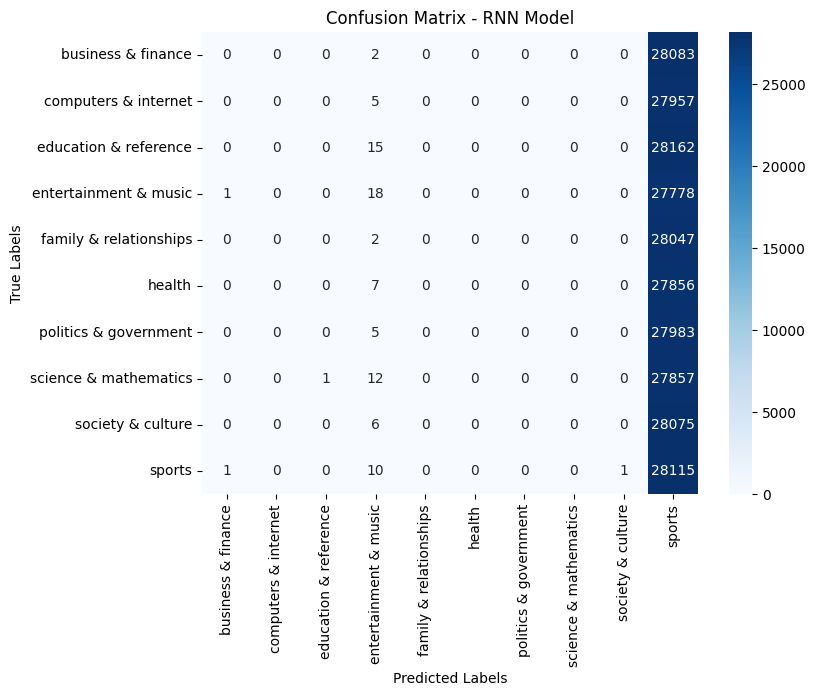

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix with seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - RNN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# bidirectional rnn

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        brnn_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            Bidirectional(SimpleRNN(32)),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])


        brnn_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        brnn_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stop]
            )

        #saving the model
        brnn_model.save("brnn_model.keras")


        test_loss, test_acc = brnn_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 677s 192ms/step - accuracy: 0.3389 - loss: 1.9142 - val_accuracy: 0.5230 - val_loss: 1.4687
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 672s 192ms/step - accuracy: 0.4102 - loss: 1.7668 - val_accuracy: 0.5034 - val_loss: 1.5243
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 672s 192ms/step - accuracy: 0.4447 - loss: 1.6753 - val_accuracy: 0.5104 - val_loss: 1.5052
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 672s 192ms/step - accuracy: 0.4700 - loss: 1.6187 - val_accuracy: 0.4676 - val_loss: 1.6267
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 493s 56ms/step - accuracy: 0.5249 - loss: 1.4612
Test Accuracy: 0.5241982936859131


In [21]:
#loading model
import tensorflow as tf
brnn_model = tf.keras.models.load_model('brnn_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = brnn_model.evaluate(X_test, y_test, verbose=0)
y_prob = brnn_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_brnn  = accuracy_score(y_true, y_pred)
precision_brnn = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_brnn  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_brnn   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_brnn   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_brnn)
print("Precision (macro):", precision_brnn)
print("Recall (macro):", recall_brnn)
print("F1 (macro):", f1_brnn)
print("Confusion Matrix:\n", cm_brnn)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy: 0.5241983007082168
Precision (macro): 0.5158838940403256
Recall (macro): 0.5244832940416927
F1 (macro): 0.511885820510387
Confusion Matrix:
 [[ 5936  4242  2943  1903  3345  1557  4192  1530  1618   819]
 [  900 22021  1120  1026   321   310   497  1123   223   421]
 [ 1770  1998  8108  1705  1531  1453  3387  4409  2643  1173]
 [  607  2089  1311 14045  3950   974  1180   625  1239  1777]
 [  766   531   756  2712 18006  2141  1231   264  1329   313]
 [  409   478   749  1116  3631 18046   950  1650   403   431]
 [ 1817   897  1514   539  1294   653 18139   679  1641   815]
 [  437  1556  3784  1089   690  3639  1120 13923   587  1045]
 [ 1266   629  2912  1808  4498  1299  4440   961  9592   676]
 [  303   939  1218  2511   803   873  1079  1006   436 18959]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.42      0.21      0.28     28085
  computers & internet       0.62      0.79      0.70     27962


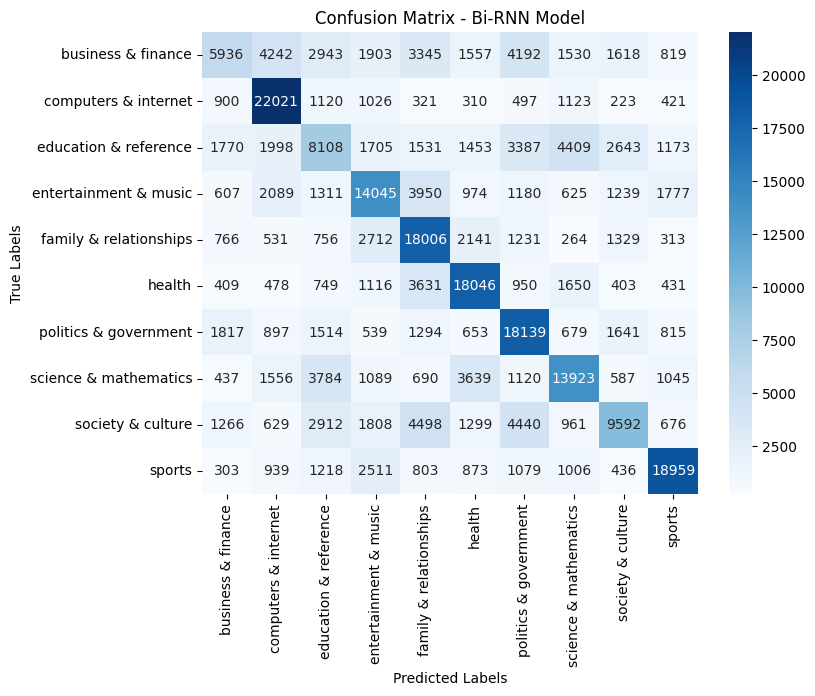

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix with seaborn for Bi-RNN
plt.figure(figsize=(8,6))
sns.heatmap(cm_brnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - Bi-RNN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# GRU

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        gru_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            GRU(32),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])


        gru_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )


        gru_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stop]
            )


        #saving the model
        gru_model.save("gru_model.keras")

        test_loss, test_acc = gru_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 156s 43ms/step - accuracy: 0.0996 - loss: 2.3031 - val_accuracy: 0.0978 - val_loss: 2.3030
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 152s 43ms/step - accuracy: 0.1014 - loss: 2.3029 - val_accuracy: 0.1027 - val_loss: 2.3027
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 151s 43ms/step - accuracy: 0.1002 - loss: 2.3029 - val_accuracy: 0.0999 - val_loss: 2.3026
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 152s 44ms/step - accuracy: 0.1000 - loss: 2.3028 - val_accuracy: 0.0993 - val_loss: 2.3029
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 151s 43ms/step - accuracy: 0.1006 - loss: 2.3029 - val_accuracy: 0.0995 - val_loss: 2.3027
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 160s 18ms/step - accuracy: 0.1004 - loss: 2.3026
Test Accuracy: 0.10045750439167023


In [24]:
#loading model
import tensorflow as tf
gru_model = tf.keras.models.load_model('gru_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = gru_model.evaluate(X_test, y_test, verbose=0)
y_prob = gru_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_gru  = accuracy_score(y_true, y_pred)
precision_gru = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_gru  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_gru   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_gru   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_gru)
print("Precision (macro):", precision_gru)
print("Recall (macro):", recall_gru)
print("F1 (macro):", f1_gru)
print("Confusion Matrix:\n", cm_gru)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy: 0.10045750163393441
Precision (macro): 0.11004542889592069
Recall (macro): 0.10000354899386024
F1 (macro): 0.01826397400357075
Confusion Matrix:
 [[    0     0     0     0     0     0     0     0     0 28085]
 [    0     0     0     0     0     0     0     0     0 27962]
 [    0     0     1     0     0     0     0     0     0 28176]
 [    0     0     0     0     0     0     0     0     0 27797]
 [    0     0     0     0     0     0     0     0     0 28049]
 [    0     0     0     0     0     0     0     0     0 27863]
 [    0     0     0     0     0     0     0     0     0 27988]
 [    0     0     0     0     0     0     0     0     0 27870]
 [    0     0     0     0     0     0     0     0     0 28081]
 [    0     0     0     0     0     0     0     0     0 28127]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.00      0.00      0.00     28085
  computers & internet       0.00      0.00      0.00     2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


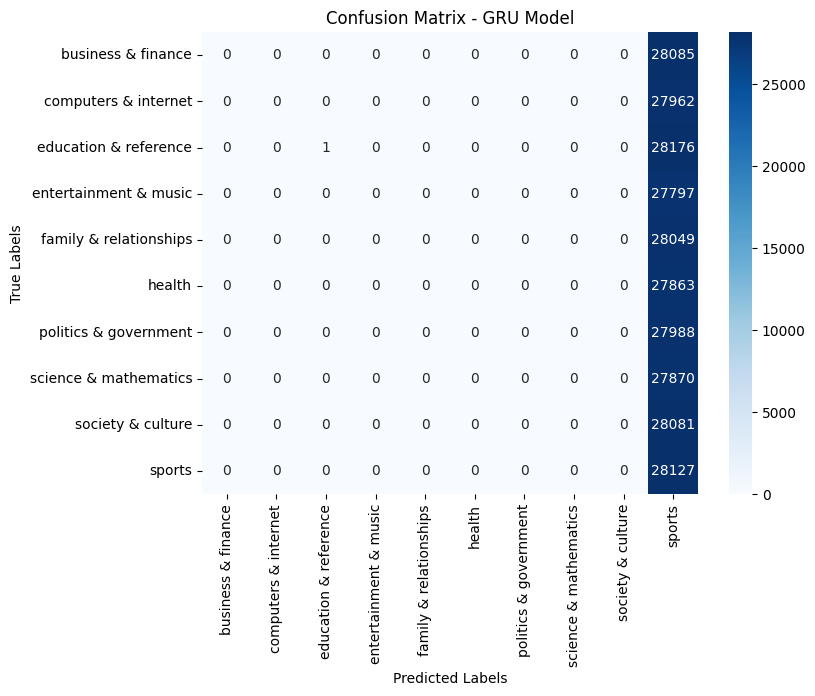

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap for GRU
plt.figure(figsize=(8,6))
sns.heatmap(cm_gru, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - GRU Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# bidirectional GRU

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        bgru_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            Bidirectional(GRU(32)),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])


        bgru_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        bgru_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=128,
            validation_split=0.2,
            callbacks=[early_stop]
            )


        #saving the model
        bgru_model.save("bgru_model.keras")

        test_loss, test_acc = bgru_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 288s 81ms/step - accuracy: 0.5076 - loss: 1.5151 - val_accuracy: 0.6484 - val_loss: 1.1107
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 282s 81ms/step - accuracy: 0.6284 - loss: 1.1968 - val_accuracy: 0.6588 - val_loss: 1.0677
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 282s 81ms/step - accuracy: 0.6405 - loss: 1.1630 - val_accuracy: 0.6644 - val_loss: 1.0546
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 283s 81ms/step - accuracy: 0.6436 - loss: 1.1476 - val_accuracy: 0.6680 - val_loss: 1.0418
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 283s 81ms/step - accuracy: 0.6459 - loss: 1.1375 - val_accuracy: 0.6700 - val_loss: 1.0344
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 287s 33ms/step - accuracy: 0.6756 - loss: 1.0142
Test Accuracy: 0.6746988296508789


In [27]:
#loading model
import tensorflow as tf
bgru_modelmodel = tf.keras.models.load_model('bgru_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = bgru_model.evaluate(X_test, y_test, verbose=0)
y_prob = bgru_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_bgru  = accuracy_score(y_true, y_pred)
precision_bgru = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_bgru  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_bgru   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_bgru   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_bgru)
print("Precision (macro):", precision_bgru)
print("Recall (macro):", recall_bgru)
print("F1 (macro):", f1_bgru)
print("Confusion Matrix:\n", cm_bgru)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy: 0.6746988382101364
Precision (macro): 0.6721251086265875
Recall (macro): 0.6748971780308176
F1 (macro): 0.6721895850280692
Confusion Matrix:
 [[13215  1637  2524  1534  2509  1320  1703  1293  1774   576]
 [ 1410 23001  1051  1062   308   115   189   488   143   195]
 [ 1946   824 13425  1232   812  1079  1823  4210  2253   573]
 [  985  1023   937 18319  2006   806   540   637  1519  1025]
 [  797   301   520  1047 21794  1248   450   184  1500   208]
 [  752   150   700   421  2053 21244   238  1242   728   335]
 [ 1989   278  1319   556   603   394 20439   432  1606   372]
 [  766   485  2795   567   293  2216   397 19069   797   485]
 [ 1290   278  2386  1700  3215  1085  1684   842 15226   375]
 [  622   241   586  1164   416   614   332   607   362 23183]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.56      0.47      0.51     28085
  computers & internet       0.82      0.82      0.82     27962

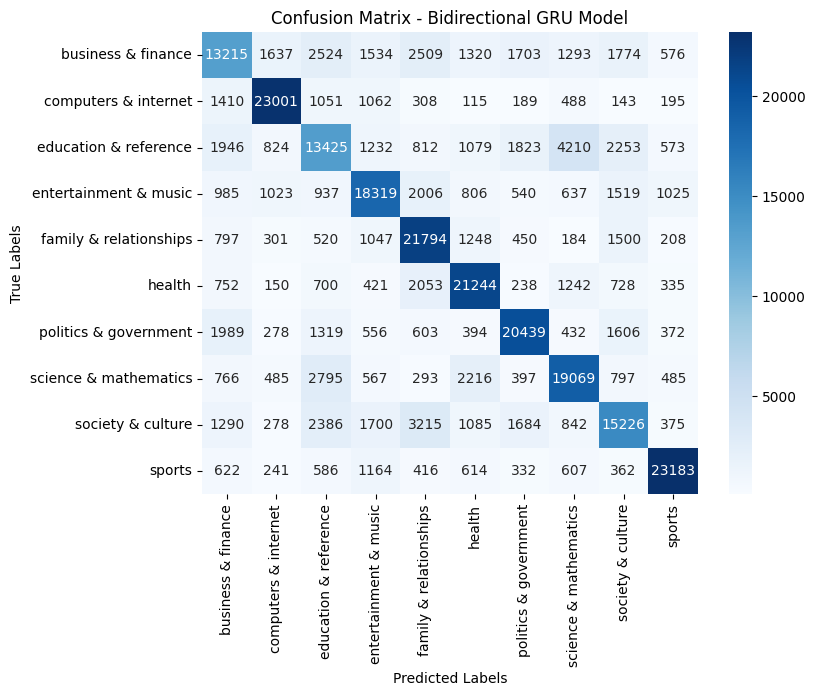

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap for Bidirectional GRU
plt.figure(figsize=(8,6))
sns.heatmap(cm_bgru, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - Bidirectional GRU Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# Lstm

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        lstm_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            LSTM(32),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])


        lstm_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )


        lstm_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=128,
            validation_split=0.2,
            callbacks=[early_stop]
            )

        #saving the model
        lstm_model.save("lstm_model.keras")

        test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 150s 42ms/step - accuracy: 0.1009 - loss: 2.3029 - val_accuracy: 0.0999 - val_loss: 2.3028
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 150s 43ms/step - accuracy: 0.0996 - loss: 2.3029 - val_accuracy: 0.0978 - val_loss: 2.3029
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 0.1011 - loss: 2.3027 - val_accuracy: 0.0999 - val_loss: 2.3027
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 149s 43ms/step - accuracy: 0.0987 - loss: 2.3028 - val_accuracy: 0.1004 - val_loss: 2.3026
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 150s 43ms/step - accuracy: 0.1010 - loss: 2.3027 - val_accuracy: 0.1004 - val_loss: 2.3027
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 159s 18ms/step - accuracy: 0.1002 - loss: 2.3026
Test Accuracy: 0.10030750185251236


In [30]:
#loading model
import tensorflow as tf
lstm_model = tf.keras.models.load_model('lstm_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = lstm_model.evaluate(X_test, y_test, verbose=0)
y_prob = lstm_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_lstm  = accuracy_score(y_true, y_pred)
precision_lstm = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_lstm  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_lstm   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_lstm   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_lstm)
print("Precision (macro):", precision_lstm)
print("Recall (macro):", recall_lstm)
print("F1 (macro):", f1_lstm)
print("Confusion Matrix:\n", cm_lstm)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy: 0.1003075010982182
Precision (macro): 0.11003042878877707
Recall (macro): 0.10000354899386024
F1 (macro): 0.01823919752711228
Confusion Matrix:
 [[28085     0     0     0     0     0     0     0     0     0]
 [27962     0     0     0     0     0     0     0     0     0]
 [28176     0     1     0     0     0     0     0     0     0]
 [27797     0     0     0     0     0     0     0     0     0]
 [28049     0     0     0     0     0     0     0     0     0]
 [27863     0     0     0     0     0     0     0     0     0]
 [27988     0     0     0     0     0     0     0     0     0]
 [27870     0     0     0     0     0     0     0     0     0]
 [28081     0     0     0     0     0     0     0     0     0]
 [28127     0     0     0     0     0     0     0     0     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.10      1.00      0.18     28085
  computers & internet       0.00      0.00      0.00     27962
 education & reference       1.00      0.00      0.00     28177
 entertainment & music       0.00      0.00      0.00     27797
family & relationships       0.00      0.00      0.00     28049
                health       0.00      0.00      0.00     27863
 politics & government       0.00      0.00      0.00     27988
 science & mathematics       0.00      0.00      0.00     27870
     society & culture       0.00      0.00      0.00     28081
                sports       0.00      0.00      0.00     28127

              accuracy                           0.10    279999
             macro avg       0.11      0.10      0.02    279999
          weighted avg       0.11      0.10      0.02    279999



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


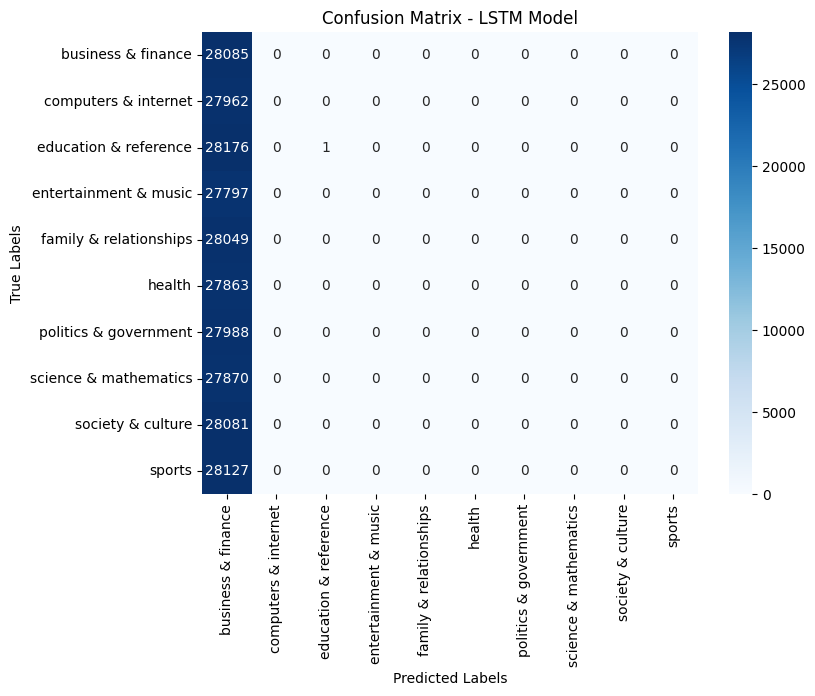

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap for LSTM
plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# bidirectional lstm

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


# Simple RNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt
with tf.device('/GPU:0'):
        blstm_model = Sequential([
            Embedding(
                input_dim=max_vocab,           # same as tokenizer num_words
                output_dim=embedding_dim,      # dimension of GloVe vectors
                weights=[embedding_matrix],    # use pre-trained GloVe embeddings
                input_length=max_len,          # padded input length
                trainable=False                # keep embeddings fixed
            ),
            Bidirectional(LSTM(32)),
            Dropout(0.5),                      # regularization
            Dense(10, activation='softmax')    # 10 classes (adjust if needed)
        ])


        blstm_model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )


        blstm_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=128,
            validation_split=0.2,
            callbacks=[early_stop]
            )

        #saving the model
        blstm_model.save("blstm_model.keras")

        test_loss, test_acc = blstm_model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 285s 80ms/step - accuracy: 0.5148 - loss: 1.5168 - val_accuracy: 0.6430 - val_loss: 1.1356
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 280s 80ms/step - accuracy: 0.6192 - loss: 1.2390 - val_accuracy: 0.6544 - val_loss: 1.0968
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 280s 80ms/step - accuracy: 0.6280 - loss: 1.2083 - val_accuracy: 0.6423 - val_loss: 1.1262
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 280s 80ms/step - accuracy: 0.6278 - loss: 1.2088 - val_accuracy: 0.6527 - val_loss: 1.0984
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 280s 80ms/step - accuracy: 0.6315 - loss: 1.1922 - val_accuracy: 0.6572 - val_loss: 1.0865
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 290s 33ms/step - accuracy: 0.6639 - loss: 1.0640
Test Accuracy: 0.6623309254646301


In [33]:
#loading model
import tensorflow as tf
blstm_model = tf.keras.models.load_model('blstm_model.keras')


#Metrics: precision / recall / F1 / confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
test_loss, test_acc = blstm_model.evaluate(X_test, y_test, verbose=0)
y_prob = blstm_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)


accuracy_blstm  = accuracy_score(y_true, y_pred)
precision_blstm = precision_score(y_true, y_pred, average='macro',   zero_division=0)
recall_blstm  = recall_score(y_true,  y_pred, average='macro',     zero_division=0)
f1_blstm   = f1_score(y_true,      y_pred, average='macro',     zero_division=0)
cm_blstm   = confusion_matrix(y_true, y_pred)


print("Accuracy:", accuracy_blstm)
print("Precision (macro):", precision_blstm)
print("Recall (macro):", recall_blstm)
print("F1 (macro):", f1_blstm)
print("Confusion Matrix:\n", cm_blstm)


# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))


Accuracy: 0.6623309368962031
Precision (macro): 0.6590491567778953
Recall (macro): 0.662508624586223
F1 (macro): 0.6585886383042221
Confusion Matrix:
 [[13313  2090  2320  1387  2409  1497  1705  1171  1469   724]
 [ 1253 24108   723   660   223   121   177   405   107   185]
 [ 2366  1099 13222  1081   843  1320  1791  3993  1771   691]
 [ 1417  1759  1015 16957  2293   847   493   662  1215  1139]
 [ 1063   400   544  1011 21703  1289   404   177  1163   295]
 [ 1063   225   636   421  2029 20628   219  1578   613   451]
 [ 2316   325  1244   433   698   431 20358   394  1337   452]
 [ 1175   638  2498   461   279  2514   444 18663   573   625]
 [ 1888   418  2493  1502  3338  1261  1934   842 13906   499]
 [  921   434   602  1108   441   717   340   640   330 22594]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.50      0.47      0.49     28085
  computers & internet       0.77      0.86      0.81     27962


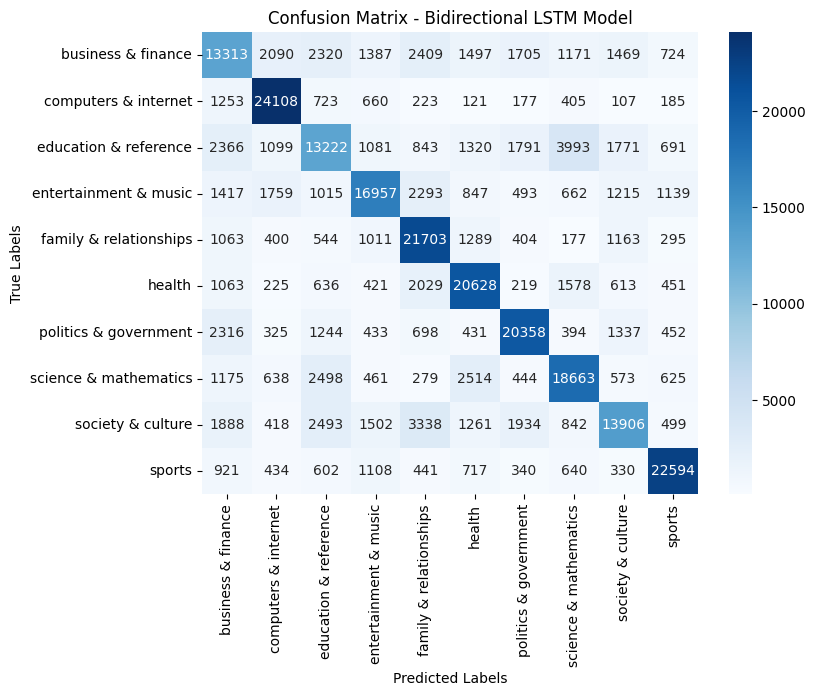

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap for Bidirectional LSTM
plt.figure(figsize=(8,6))
sns.heatmap(cm_blstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - Bidirectional LSTM Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# dnn


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# DNN Classifier
max_len = max_len_title + max_len_content + max_len_answer
embedding_dim = embedding_matrix.shape[1]  # e.g., 100 if using glove.6B.100d.txt

with tf.device('/GPU:0'):
    dnn_model = Sequential([
        Embedding(
            input_dim=max_vocab,           # same as tokenizer num_words
            output_dim=embedding_dim,      # dimension of GloVe vectors
            weights=[embedding_matrix],    # use pre-trained GloVe embeddings
            input_length=max_len,          # padded input length
            trainable=False                # keep embeddings fixed
        ),
        Flatten(),                         # flatten embeddings into vector
        Dense(128, activation='relu'),     # fully connected layer
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')    # adjust output classes if needed
    ])

    dnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    dnn_model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop]
    )

    # saving the model
    dnn_model.save("dnn_model.keras")

    test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.4520 - loss: 1.6585 - val_accuracy: 0.6377 - val_loss: 1.1627
Epoch 2/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6029 - loss: 1.2762 - val_accuracy: 0.6466 - val_loss: 1.1234
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6319 - loss: 1.1871 - val_accuracy: 0.6531 - val_loss: 1.1030
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6465 - loss: 1.1409 - val_accuracy: 0.6514 - val_loss: 1.1009
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6583 - loss: 1.0999 - val_accuracy: 0.6521 - val_loss: 1.0990
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.7216 - loss: 0.8665
Test Accuracy: 0.7099132537841797


In [40]:
# -------------------- Evaluation --------------------
dnn_model = tf.keras.models.load_model('dnn_model.keras')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_prob = dnn_model.predict(X_test, batch_size=512, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
accuracy_dnn  = accuracy_score(y_true, y_pred)
precision_dnn = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_dnn    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_dnn        = f1_score(y_true, y_pred, average='macro', zero_division=0)
cm_dnn        = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy_dnn)
print("Precision (macro):", precision_dnn)
print("Recall (macro):", recall_dnn)
print("F1 (macro):", f1_dnn)
print("Confusion Matrix:\n", cm_dnn)

# Optional: class names if you used a LabelEncoder earlier
labels = label_encoder.classes_.tolist() if 'label_encoder' in globals() else None
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=labels))

Accuracy: 0.7099132496901774
Precision (macro): 0.7071489766956024
Recall (macro): 0.7102642000431144
F1 (macro): 0.6990256596917024
Confusion Matrix:
 [[12817  2228  1681  1405  2867  1355  2269  1313  1349   801]
 [  657 25499   280   473   216    67   155   277   112   226]
 [ 1446  1422 11046  1135   962  1051  2780  5232  2391   712]
 [  408  1610   449 19206  2196   696   630   459   967  1176]
 [  391   414   269  1034 22954  1093   502   119   954   319]
 [  352   231   244   255  1826 22778   282  1176   341   378]
 [ 1229   432   467   340   548   298 23242   332   740   360]
 [  256   807  1042   359   169  1771   500 22128   425   413]
 [  629   452  1325  1508  4205  1075  3024   831 14552   480]
 [  266   407   228   924   352   493   305   442   157 24553]]

Classification Report:
                         precision    recall  f1-score   support

    business & finance       0.69      0.46      0.55     28085
  computers & internet       0.76      0.91      0.83     27962

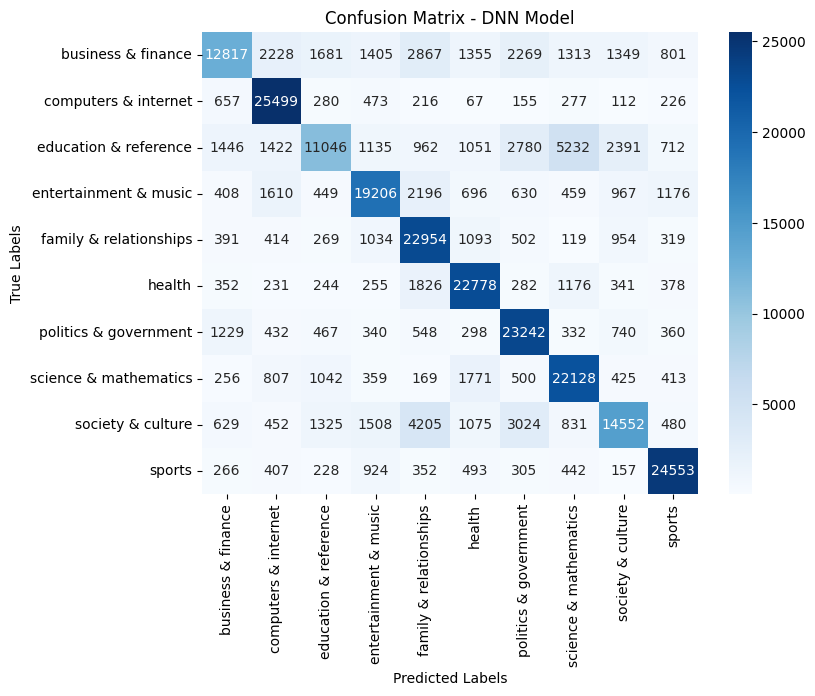

In [41]:

# Confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_dnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels if labels else None,
            yticklabels=labels if labels else None)

plt.title("Confusion Matrix - DNN Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# model comparison

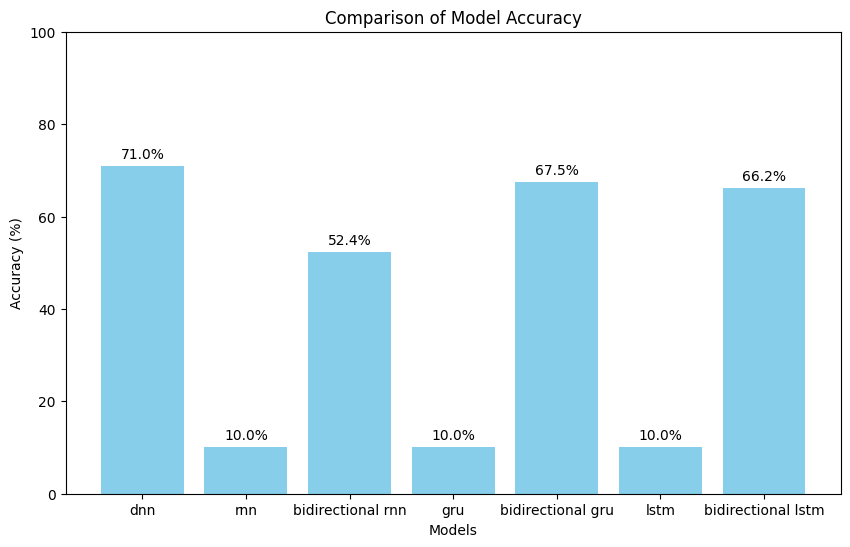

In [43]:
import matplotlib.pyplot as plt

# Model names (7 models including DNN)
model_names = ['dnn', 'rnn', 'bidirectional rnn', 'gru', 'bidirectional gru', 'lstm', 'bidirectional lstm']
accuracy_scores = [accuracy_dnn, accuracy_rnn, accuracy_brnn, accuracy_gru, accuracy_bgru, accuracy_lstm, accuracy_blstm]
accuracy_scores_percent = [a * 100 for a in accuracy_scores]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_scores_percent, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 100)  # y-axis in percentage

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', 
             ha='center', va='bottom')

plt.show()


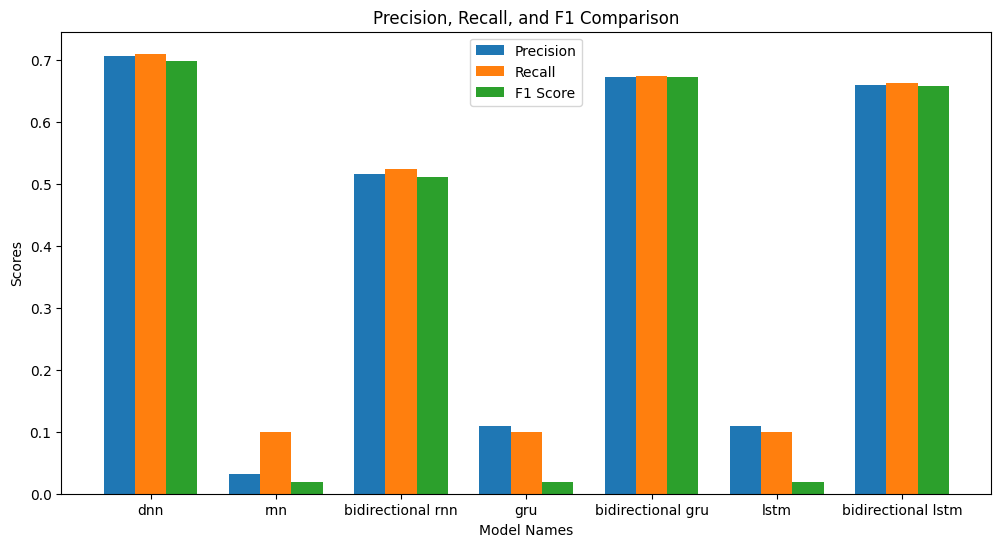

In [46]:
import matplotlib.pyplot as plt

# Precision, Recall, F1 score Comparison
model_names = ['dnn', 'rnn', 'bidirectional rnn', 'gru', 'bidirectional gru', 'lstm', 'bidirectional lstm']
precision_scores = [precision_dnn, precision_rnn, precision_brnn, precision_gru, precision_bgru, precision_lstm, precision_blstm]
recall_scores    = [recall_dnn,   recall_rnn,   recall_brnn,   recall_gru,   recall_bgru,   recall_lstm,   recall_blstm]
f1_scores        = [f1_dnn,       f1_rnn,       f1_brnn,       f1_gru,       f1_bgru,       f1_lstm,       f1_blstm]

x = range(len(model_names))
width = 0.25  

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars
rects1 = ax1.bar([i - width for i in x], precision_scores, width, label='Precision')
rects2 = ax1.bar(x, recall_scores, width, label='Recall')
rects3 = ax1.bar([i + width for i in x], f1_scores, width, label='F1 Score')

# Labels and title
ax1.set_xlabel('Model Names')
ax1.set_ylabel('Scores')
ax1.set_title('Precision, Recall, and F1 Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()

plt.show()


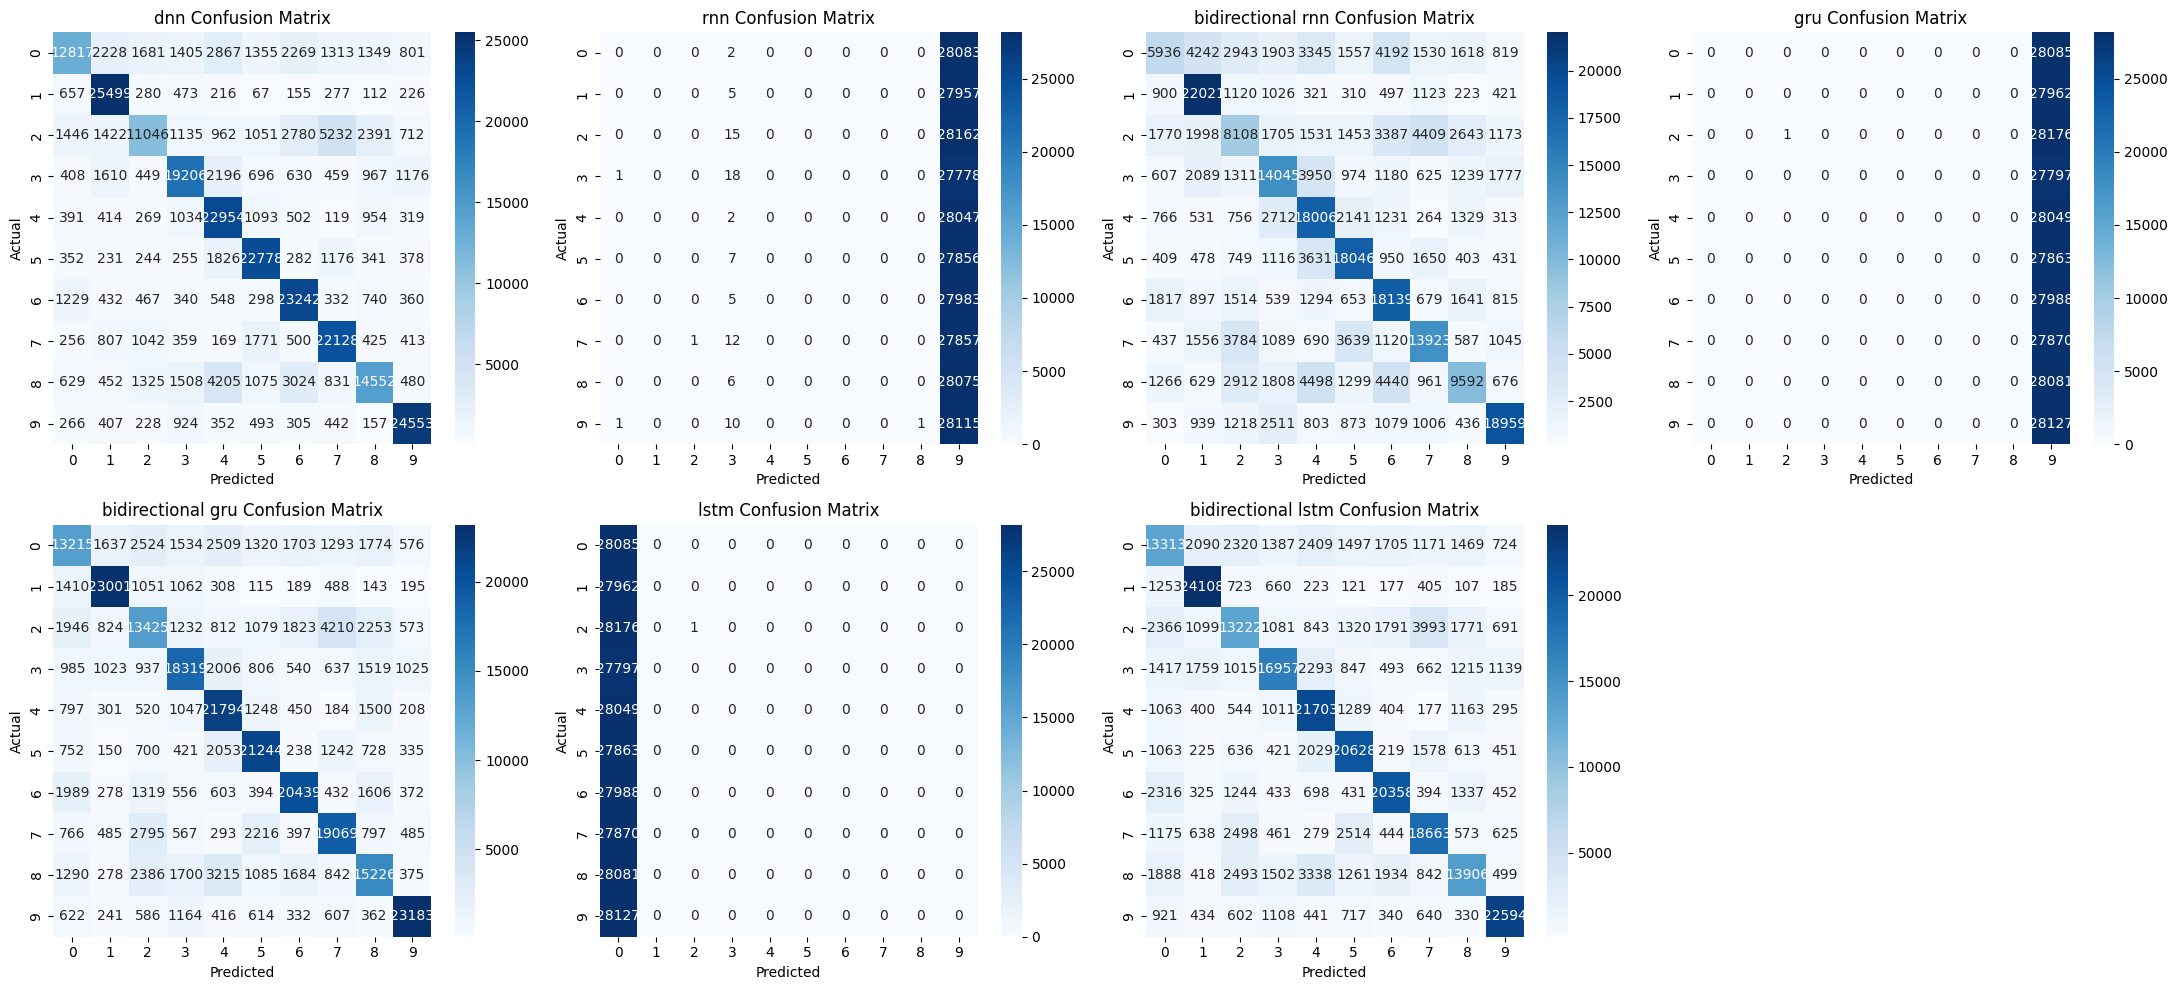

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
model_names = ['dnn', 'rnn', 'bidirectional rnn', 'gru', 'bidirectional gru', 'lstm', 'bidirectional lstm']
confusion_matrices = [cm_dnn, cm_rnn, cm_brnn, cm_gru, cm_bgru, cm_lstm, cm_blstm]
# Plot confusion matrices (2 rows x 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()  # Flatten 2D array of axes for easy iteration
for i, ax in enumerate(axes[:len(model_names)]):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{model_names[i]} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
# Hide unused subplot (since 2x4 = 8 slots but we have 7 models)
if len(model_names) < len(axes):
    axes[-1].axis('off')
plt.tight_layout()
plt.show()